#Importing the necessary libraries and mounting drive to load the dataset


In [ ]:
import pandas as pd
import numpy as np
import re
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading the required datasets

In [ ]:
da=pd.read_csv('/content/drive/MyDrive/DataAnalystJobs.csv')
de=pd.read_csv('/content/drive/MyDrive/DataEngineer.csv')
ds=pd.read_csv('/content/drive/MyDrive/DataScientist.csv')
da=da.drop(da.columns[0],axis=1)
ds=ds.drop(ds.columns[0],axis=1)
df_comb=pd.concat([da,ds,de])
df_comb=df_comb.drop_duplicates()

##Displaying the first few rows of the combined dataset

In [ ]:
df_comb.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply,index
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True,NaN
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1,NaN
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1,NaN
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1,NaN
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True,NaN


# Data Cleaning, Domain Knowledge Preprocessing, and Dimension Reduction

##Feature Selection (Dimension Reduction)

In [ ]:
#dropping unneccesary columns
df_comb.drop(columns = ['Competitors','Easy Apply','Industry'], inplace=True)
df_comb = df_comb.dropna()
df_comb=df_comb.drop(index=df_comb[(df_comb['Revenue']=='Unknown / Non-Applicable') | (df_comb['Size']=='Unknown')].index)

In [ ]:
df_comb = df_comb.reset_index(drop=True)

In [ ]:
df_comb.shape

(2742, 13)

In [ ]:
df_comb.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,2742.0,3.308862,1.484653,-1.0,3.30,3.7,4.10,5.0
Founded,2742.0,1540.315828,811.148524,-1.0,1849.00,1970.0,1999.00,2020.0
index,2742.0,2242.022611,1226.415699,11.0,1231.25,2242.5,3307.75,4379.0


In [ ]:
df_comb.isnull().sum()

Job Title            0
Salary Estimate      0
Job Description      0
Rating               0
Company Name         0
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Sector               0
Revenue              0
index                0
dtype: int64

##Cleaning Salary Estimate column

In [ ]:
df_comb.dropna(subset=['Salary Estimate'],inplace=True)        
#Removing the text value from the column
df_comb['Salary Estimate'] = df_comb['Salary Estimate'].astype(str)
salary = df_comb['Salary Estimate'].apply(lambda x: x.split("(")[0])
salary
#Removing $ and K from the column
salary = salary.apply(lambda x: x.replace("$","").replace("K",""))
salary
#Creating column for per hour
df_comb['salary_per_hour'] = salary.apply(lambda x: 1 if "per hour" in x.lower() else 0)
salary = salary.apply(lambda x: x.lower().replace("per hour","").replace(" ",""))

#minimum salary
df_comb["min_salary"] = salary.apply(lambda x: x.split("-")[0]).astype(int)
#maximum salary
df_comb["max_salary"] = salary.apply(lambda x: x.split("-")[1]).astype(int)
#converting the hourly salaries to annual salaries
df_comb['min_salary'] = df_comb.apply(lambda x: x['min_salary']*1.92 if x["salary_per_hour"]==1 else x['min_salary'], axis =1).apply(lambda x:x*1000)
df_comb['max_salary'] = df_comb.apply(lambda x: x['max_salary']*1.92 if x["salary_per_hour"]==1 else x['max_salary'], axis =1).apply(lambda x:x*1000)

##Cleaning company name column

In [ ]:
def clean_company_name(value):
  parts = value.split('\n')
  return parts[0].strip()
df_comb['Company Name'] = df_comb['Company Name'].astype(str)
df_comb['Company Name'] = df_comb['Company Name'].apply(clean_company_name)

##Creating a job_state column

In [ ]:
df_comb["job_state"] = df_comb["Location"].apply(lambda x: x.split(',')[1])
df_comb["job_state"] = df_comb["job_state"].apply(lambda x: x.strip() if x.strip().lower()!=("arapahoe") else 'AC')
df_comb["job_state"] = df_comb["job_state"].apply(lambda x: x.strip() if x.strip().lower()!=("united kingdom") else 'UK')
df_comb["job_state"].value_counts()

TX    920
CA    739
IL    239
AZ    226
PA    220
NY    168
OH    142
FL     55
NJ     21
DE      8
UK      4
Name: job_state, dtype: int64

##Finding company age from founded column

In [ ]:
#df_comb[df_comb['Founded']=='<NA>']
df_comb['Founded'].replace('<NA>',np.nan,inplace=True)
df_comb['Founded']=pd.to_numeric(df_comb['Founded'])
df_comb['Founded'].isna().mean()*100 # 25% missing values
#FInding company's age based on 2023
def age(value):
  if(pd.isna(value)):
    return None
  else:
    return(2023-int(value))
df_comb["Company_age"] = df_comb["Founded"].apply(age)

##Cleaning Job-Title coloumn

In [ ]:
from nltk import FreqDist
df_comb["Job Title"]=df_comb["Job Title"].apply(lambda x:x.lower())
all_jobs = (' '.join(df_comb['Job Title'])).split()
fdist = FreqDist(all_jobs)
def job_title(v):
  if(("data scientist" in v) or ("data science" in v)):
    return "data scientist"
  elif(('analyst' in v) or ("analytics" in v) or ('analysis' in v) or ("quantitative" in v) or ("visualization" in v) or ('data consultant' in v)):
    return "analyst"
  elif(("data engineer" in v) or ("big data" in v) or ("etl" in v) or ('data integration' in v) or ('data infrastructure' in v) or ('data network' in v)):
    return "data engineer"
  elif("machine learning" in v):
    return "machine learning engineer"
  elif(("artificial intelligence" in v) or ("ai" in v)):
    return "AI engineer"
  elif("cloud engineer" in v):
    return "cloud engineer"
  elif("manager" in v):
    return "manager"
  elif("director" in v):
    return "director"
  else:
    return "others"
df_comb["job_desc_simp"]=df_comb['Job Title'].apply(job_title)
df_comb[(df_comb['job_desc_simp']=="others") & (df_comb['Job Title'].str.contains('data', case=False))]
df_comb['job_desc_simp'].value_counts()

data scientist               782
analyst                      730
others                       595
data engineer                534
machine learning engineer     79
AI engineer                   15
director                       4
manager                        3
Name: job_desc_simp, dtype: int64

##Adding a seniority column

In [ ]:
def seniority(v):
  if(("sr." in v) or ("senior" in v) or ('sr' in v) or ("lead" in v)):
    return "senior"
  elif(("jr." in v) or ("junior" in v) or ('jr' in v) or ('entry' in v)):
    return "junior"
  else:
    return 'na'
df_comb['seniority']=df_comb['Job Title'].apply(seniority)
df_comb['seniority'].value_counts()

na        2143
senior     558
junior      41
Name: seniority, dtype: int64

##Preprocessing Type of ownership column 

In [ ]:
def ownership(v):
  if((pd.isna(v)) or v==-1):
    return "other organisations"
  if(('private' in v.lower()) or ('franchise' in v.lower()) or ('self-employed' in v.lower())):
    return "private"
  elif(('public' in v.lower())):
    return "public"
  elif(("school" in v.lower()) or ("college" in v.lower()) or ('university' in v.lower())):
    return "education_institution"
  elif("government" in v.lower()):
    return("government")
  else:
    return "other organisations"
df_comb['Type of ownership']= df_comb['Type of ownership'].apply(ownership)

##Preprocessing Company Size column

In [18]:
size_mapping = {
    '1 to 50 employees': 'Small',
    '51 to 200 employees': 'Small',
    '201 to 500 employees': 'Small',
    '501 to 1000 employees': 'Medium',
    '1001 to 5000 employees': 'Medium',
    '5001 to 10000 employees': 'Large',
    '10000+ employees': 'Large'
}
df_comb['size_category'] = df_comb['Size'].map(size_mapping)
df_comb['size_category'].value_counts()

Large     1064
Small      876
Medium     573
Name: size_category, dtype: int64

##Preprocessing Revenue Column

In [19]:
revenue_mapping = {
    'Less than $1 million (USD)': 'Low',
    '$1 to $5 million (USD)': 'Low',
    '$5 to $10 million (USD)': 'Low',
    '$10 to $25 million (USD)': 'Medium',
    '$25 to $50 million (USD)': 'Medium',
    '$50 to $100 million (USD)': 'Medium',
    '$100 to $500 million (USD)': 'High',
    '$500 million to $1 billion (USD)': 'High',
    '$1 to $2 billion (USD)': 'High',
    '$2 to $5 billion (USD)': 'Very High',
    '$5 to $10 billion (USD)': 'Very High',
    '$10+ billion (USD)': 'Very High'
}
df_comb['revenue_category'] = df_comb['Revenue'].map(revenue_mapping)
df_comb['revenue_category'].value_counts()

Very High    943
High         632
Medium       546
Low          392
Name: revenue_category, dtype: int64

##Preprocessing Job description column based on the skills present in the JD

In [20]:
ds0=[
 'excel',
 'python',
 'sql',
 'machine learning','spark',
 'aws']
ski = pd.DataFrame(0, index=range(len(df_comb)), columns=ds0)
for i in range(len(df_comb)):
  tt=df_comb.iloc[i,2]
  ss=str(tt)
  for j in ds0:
    if ss.lower().find(j.lower()) != -1:
      ski.loc[i,j]=1
    else:
      continue
#df_comb=pd.concat([df_comb, ski], axis=1)


In [21]:
ski

,excel,python,sql,machine learning,spark,aws
0,0,1,0,1,1,0
1,0,1,1,1,0,1
2,0,1,1,0,0,0
3,0,1,1,1,1,0
4,0,1,1,0,0,0
...,...,...,...,...,...,...
2737,0,0,0,0,0,1
2738,1,0,1,0,0,0
2739,1,1,1,1,0,0
2740,1,1,1,1,0,0


In [22]:
ski.sum()

excel               1333
python              1421
sql                 1422
machine learning     897
spark                689
aws                  677
dtype: int64

##Preprocessing Job State column

In [23]:
(df_comb['job_state'].unique())

array(['NY', 'NJ', 'CA', 'IL', 'TX', 'AZ', 'DE', 'PA', 'UK', 'FL', 'OH'],
      dtype=object)

In [24]:
st=pd.DataFrame(df_comb['job_state'].value_counts())
st['name']=st.index
st.index=range(0,len(st))
st=st.head(9)
sts=list(st['name'].values)
def states(v):
  if v not in sts:
    return "Others"
  else:
    return v
df_comb["job_state"]=df_comb['job_state'].apply(states)
df_comb['job_in_hq']=df_comb.apply(lambda x: 1 if x['Location']==x['Headquarters'] else 0, axis=1)

In [25]:
df_comb

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,salary_per_hour,min_salary,max_salary,job_state,Company_age,job_desc_simp,seniority,size_category,revenue_category,job_in_hq
0,data scientist/machine learning,$111K-$181K (Glassdoor est.),"PulsePoint™, a global programmatic advertising...",4.4,PulsePoint,"New York, NY","New York, NY",51 to 200 employees,2011,private,...,0,111000.0,181000.0,NY,12,data scientist,na,Small,High,1
1,"data scientist, acorn ai labs",$111K-$181K (Glassdoor est.),Medidata: Conquering Diseases Together\n\nMedi...,4.3,Medidata Solutions,"New York, NY","New York, NY",1001 to 5000 employees,1999,public,...,0,111000.0,181000.0,NY,24,data scientist,na,Medium,High,1
2,"data scientist, analytics",$111K-$181K (Glassdoor est.),"Company DescriptionAs an Etsy employee, you ca...",3.6,Etsy,"Brooklyn, NY","Brooklyn, NY",501 to 1000 employees,2005,public,...,0,111000.0,181000.0,NY,18,data scientist,na,Medium,High,1
3,data scientist/ml engineer,$111K-$181K (Glassdoor est.),Data Scientist/ML Engineer\n\nApply Now\n\nBec...,3.3,PA Consulting,"New York, NY","London, United Kingdom",1001 to 5000 employees,1943,private,...,0,111000.0,181000.0,NY,80,data scientist,na,Medium,High,0
4,data scientist,$111K-$181K (Glassdoor est.),Job Description\nCompany Description\n\nAs an ...,3.6,Etsy,"New York, NY","Brooklyn, NY",501 to 1000 employees,2005,public,...,0,111000.0,181000.0,NY,18,data scientist,na,Medium,High,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,aws data engineer,$55K-$112K (Glassdoor est.),About Us\n\nTachyon Technologies is a Digital ...,4.4,Tachyon Technologies,"Dublin, OH","Irving, TX",201 to 500 employees,2011,private,...,0,55000.0,112000.0,OH,12,data engineer,na,Small,Medium,0
2738,data analyst â junior,$55K-$112K (Glassdoor est.),"Job description\nInterpret data, analyze resul...",5.0,"Staffigo Technical Services, LLC","Columbus, OH","Woodridge, IL",51 to 200 employees,2008,private,...,0,55000.0,112000.0,OH,15,analyst,junior,Small,Medium,0
2739,security analytics data engineer,$55K-$112K (Glassdoor est.),Job DescriptionThe Security Analytics Data Eng...,3.8,"PDS Tech, Inc.","Dublin, OH","Irving, TX",5001 to 10000 employees,1977,private,...,0,55000.0,112000.0,OH,46,analyst,na,Large,High,0
2740,security analytics data engineer,$55K-$112K (Glassdoor est.),The Security Analytics Data Engineer will inte...,4.0,Data Resource Technologies,"Dublin, OH","Omaha, NE",1 to 50 employees,-1,private,...,0,55000.0,112000.0,OH,2024,analyst,na,Small,Low,0


## Creating Seniority Rank column by further preprocessing seniority column

In [26]:
seniority_map={'na':0,'junior':1,'senior':2}
df_comb['seniority_rank']=df_comb['seniority'].map(seniority_map)

In [27]:
df_comb['seniority_rank'].value_counts()

0    2143
2     558
1      41
Name: seniority_rank, dtype: int64

##One hot encoding of categorical columns (dimension reduction)

In [28]:
sect_encoded = pd.get_dummies(df_comb['Sector'])
owner_encoded=pd.get_dummies(df_comb['Type of ownership'])
sts_encoded=pd.get_dummies(df_comb['job_state'])
title_encoded=pd.get_dummies(df_comb['job_desc_simp'])
revenue_cat=pd.get_dummies(df_comb['revenue_category'])
size_cat=pd.get_dummies(df_comb['size_category'])
drop_column=['Company Name','job_desc_simp','job_state','Location','Job Description', 'salary_per_hour','Headquarters', 'Job Title','Salary Estimate', 'Size','size_category','revenue_category', 'Founded','Type of ownership', 'Sector','Revenue','seniority']
model=df_comb.drop(labels=drop_column,axis=1)
df_mod=pd.concat([model,sect_encoded,owner_encoded,sts_encoded,title_encoded,revenue_cat,size_cat,ski],axis=1)

#Final modified dataset after data cleaning and preprocessing

In [ ]:
df_mod

,Rating,index,min_salary,max_salary,Company_age,job_in_hq,seniority_rank,-1,Accounting & Legal,Aerospace & Defense,...,Very High,Large,Medium,Small,excel,python,sql,machine learning,spark,aws
0,4.4,11.0,111000.0,181000.0,12,1,0,0,0,0,...,0,0,0,1,0,1,0,1,1,0
1,4.3,12.0,111000.0,181000.0,24,1,0,0,0,0,...,0,0,1,0,0,1,1,1,0,1
2,3.6,16.0,111000.0,181000.0,18,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
3,3.3,17.0,111000.0,181000.0,80,0,0,0,0,0,...,0,0,1,0,0,1,1,1,1,0
4,3.6,18.0,111000.0,181000.0,18,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,4.4,4375.0,55000.0,112000.0,12,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2738,5.0,4376.0,55000.0,112000.0,15,0,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
2739,3.8,4377.0,55000.0,112000.0,46,0,0,0,0,0,...,0,1,0,0,1,1,1,1,0,0
2740,4.0,4378.0,55000.0,112000.0,2024,0,0,0,1,0,...,0,0,0,1,1,1,1,1,0,0


#Data Modeling

##Data set split into test train, predictors and response variable 

In [ ]:
y1=df_mod['min_salary'].values
y2=df_mod['max_salary'].values
x=df_mod.drop(labels=['min_salary','max_salary'],axis=1)

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#fit and transform the dataframe using MinMaxScaler
x_normalized = (pd.DataFrame(scaler.fit_transform(x), columns=x.columns)).round(3)

x_normalized

,Rating,index,Company_age,job_in_hq,seniority_rank,-1,Accounting & Legal,Aerospace & Defense,"Arts, Entertainment & Recreation",Biotech & Pharmaceuticals,...,Very High,Large,Medium,Small,excel,python,sql,machine learning,spark,aws
0,0.900,0.000,0.004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.883,0.000,0.010,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,0.767,0.001,0.007,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.717,0.001,0.038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
4,0.767,0.002,0.007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,0.900,0.999,0.004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2738,1.000,0.999,0.006,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2739,0.800,1.000,0.021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2740,0.833,1.000,1.000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y1_train,y1_test=train_test_split(x_normalized,y1,test_size=0.20,random_state=42)
x_train,x_test,y2_train,y2_test=train_test_split(x_normalized,y2,test_size=0.20,random_state=42)

##Prediction Models

###Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
lr_model1=LinearRegression()
lr_model1.fit(x_train,y1_train)
lr_model2=LinearRegression()
lr_model2.fit(x_train,y2_train)
y_pred_lr1 = lr_model1.predict(x_test)
y_pred_lr2 = lr_model2.predict(x_test)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# Create a data frame to store the performance metrics
lr_df1 = pd.DataFrame({'Accuracy_training': [lr_model1.score(x_train, y1_train)], 'R2 Score_training': [r2_score(y1_train, lr_model1.predict(x_train))], 'RMSE_training': [mean_squared_error(y1_train, lr_model1.predict(x_train),squared=False)],'Accuracy_test': [lr_model1.score(x_test, y1_test)], 'R2 Score_test': [r2_score(y1_test, y_pred_lr1)], 'RMSE_test': [mean_squared_error(y1_test, y_pred_lr1,squared=False)]})

# Print the data frame
print("Training vs Testing Score for Linear regression for min_salary")
lr_df1

Training vs Testing Score for Linear regression for min_salary


,Accuracy_training,R2 Score_training,RMSE_training,Accuracy_test,R2 Score_test,RMSE_test
0,0.341448,0.341448,27878.544454,0.282702,0.282702,27924.942326


In [ ]:
# Create a data frame to store the performance metrics
lr_df2 = pd.DataFrame({'Accuracy_training': [lr_model2.score(x_train, y2_train)], 'R2 Score_training': [r2_score(y2_train, lr_model2.predict(x_train))], 'RMSE_training': [mean_squared_error(y2_train, lr_model2.predict(x_train),squared=False)],'Accuracy_test': [lr_model2.score(x_test, y2_test)], 'R2 Score': [r2_score(y2_test, y_pred_lr2)], 'RMSE': [mean_squared_error(y2_test, y_pred_lr2,squared=False)]})

# Print the data frame
print("Testing Score for Linear regression for max_salary")
lr_df2

Testing Score for Linear regression for max_salary


,Accuracy_training,R2 Score_training,RMSE_training,Accuracy_test,R2 Score,RMSE
0,0.275463,0.275463,38016.807783,0.225626,0.225626,39786.189849


###Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
decision_model1=DecisionTreeRegressor(criterion='squared_error',max_depth=4,random_state=42)
decision_model2=DecisionTreeRegressor(criterion='squared_error',max_depth=4,random_state=42)
decision_model1.fit(x_train,y1_train)
decision_model2.fit(x_train,y2_train)

y_dt1=decision_model1.predict(x_test)
y_dt2=decision_model2.predict(x_test)

dt_df1 = pd.DataFrame({'Accuracy train': [decision_model1.score(x_train, y1_train)], 'R2 Score train': [r2_score(y1_train, decision_model1.predict(x_train))], 'RMSE train': [mean_squared_error(y1_train, decision_model1.predict(x_train),squared=False)], 'Accuracy_test': [decision_model1.score(x_test, y1_test)], 'R2 Score test': [r2_score(y1_test, y_dt1)],'RMSE test': [mean_squared_error(y1_test, y_dt1,squared=False)]})

# Print the data frame
print("Training VS Testing Score for decision tree regressor for minimum salary")
dt_df1

Training VS Testing Score for decision tree regressor for minimum salary


,Accuracy train,R2 Score train,RMSE train,Accuracy_test,R2 Score test,RMSE test
0,0.483564,0.483564,24687.860538,0.431993,0.431993,24849.592498


In [ ]:
dt_df2 = pd.DataFrame({'Accuracy train': [decision_model2.score(x_train, y2_train)], 'R2 Score train': [r2_score(y2_train, decision_model2.predict(x_train))], 'RMSE train': [mean_squared_error(y2_train, decision_model2.predict(x_train),squared=False)], 'Accuracy_test': [decision_model2.score(x_test, y2_test)], 'R2 Score test': [r2_score(y2_test, y_dt2)],'RMSE test': [mean_squared_error(y2_test, y_dt2,squared=False)]})

# Print the data frame
print("Training VS Testing Score for decision tree regressor for maximum salary")
dt_df2

Training VS Testing Score for decision tree regressor for maximum salary


,Accuracy train,R2 Score train,RMSE train,Accuracy_test,R2 Score test,RMSE test
0,0.434335,0.434335,33591.170519,0.440809,0.440809,33809.376441


### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_model1=RandomForestRegressor(n_estimators=100,criterion="squared_error",random_state=42)
forest_model2=RandomForestRegressor(n_estimators=100,criterion="squared_error",random_state=42)
forest_model1.fit(x_train,y1_train)
forest_model2.fit(x_train,y2_train)

y_rf1=forest_model1.predict(x_test)
y_rf2=forest_model2.predict(x_test)

rf_df1 = pd.DataFrame({'Accuracy train': [forest_model1.score(x_train, y1_train)], 'R2 Score train': [r2_score(y1_train, forest_model1.predict(x_train))], 'RMSE train': [mean_squared_error(y1_train, forest_model1.predict(x_train),squared=False)],'Accuracy_test':[forest_model1.score(x_test, y1_test)], 'R2 Score test':[r2_score(y1_test, y_rf1)], 'RMSE test': [mean_squared_error(y1_test, y_rf1,squared=False)]})

# Print the data frame
print("Training vs Testing Score for Random Forest regressor for minimum salary")
rf_df1


Training vs Testing Score for Random Forest regressor for minimum salary


,Accuracy train,R2 Score train,RMSE train,Accuracy_test,R2 Score test,RMSE test
0,0.991921,0.991921,3087.907958,0.927122,0.927122,8901.02863


In [ ]:
rf_df2 = pd.DataFrame({'Accuracy train': [forest_model2.score(x_train, y2_train)], 'R2 Score train': [r2_score(y2_train, forest_model2.predict(x_train))], 'RMSE train': [mean_squared_error(y2_train, forest_model2.predict(x_train),squared=False)],'Accuracy_test':[forest_model2.score(x_test, y2_test)], 'R2 Score test':[r2_score(y2_test, y_rf2)], 'RMSE test': [mean_squared_error(y2_test, y_rf2,squared=False)]})

# Print the data frame
print("Training vs Testing Score for Random Forest regressor for maximum salary")
rf_df2

Training vs Testing Score for Random Forest regressor for maximum salary


,Accuracy train,R2 Score train,RMSE train,Accuracy_test,R2 Score test,RMSE test
0,0.978316,0.978316,6576.864288,0.855392,0.855392,17193.043761


### AdaBoostRegressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
adb_model1=AdaBoostRegressor(base_estimator=decision_model1,n_estimators=250,learning_rate=2,random_state=42)
adb_model2=AdaBoostRegressor(base_estimator=decision_model2,n_estimators=250,learning_rate=2,random_state=42)
adb_model1.fit(x_train,y1_train)
adb_model2.fit(x_train,y2_train)

y_adb1=adb_model1.predict(x_test)
y_adb2=adb_model2.predict(x_test)

adb_df1= pd.DataFrame({'Accuracy train': [adb_model1.score(x_train, y1_train)], 'R2 Score train': [r2_score(y1_train, adb_model1.predict(x_train))], 'RMSE train': [mean_squared_error(y1_train, adb_model1.predict(x_train),squared=False)],'Accuracy_test':[adb_model1.score(x_test,y1_test)],'R2 Score test':[r2_score(y1_test,y_adb1)], 'RMSE test': [mean_squared_error(y1_test,y_adb1,squared=False)]})

print("Training vs Testing Score for Adaboost regressor for min salary")
adb_df1

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training vs Testing Score for Adaboost regressor for min salary


,Accuracy train,R2 Score train,RMSE train,Accuracy_test,R2 Score test,RMSE test
0,0.623991,0.623991,21065.616116,0.568453,0.568453,21659.908526


In [ ]:
adb_df2= pd.DataFrame({'Accuracy train': [adb_model2.score(x_train, y2_train)], 'R2 Score train': [r2_score(y2_train, adb_model2.predict(x_train))], 'RMSE train': [mean_squared_error(y2_train, adb_model2.predict(x_train),squared=False)],'Accuracy_test':[adb_model2.score(x_test,y2_test)],'R2 Score test':[r2_score(y2_test,y_adb2)], 'RMSE test': [mean_squared_error(y2_test,y_adb2,squared=False)]})

print("Training vs Testing Score for Adaboost regressor for max salary")
adb_df2

Training vs Testing Score for Adaboost regressor for max salary


,Accuracy train,R2 Score train,RMSE train,Accuracy_test,R2 Score test,RMSE test
0,0.509741,0.509741,31272.190385,0.48286,0.48286,32513.310565


##Classification Models


In [ ]:
avg=(y1+y2)/2
median_salary = sorted(avg)[len(avg)//2]

# calculate the low and high threshold salaries
low = median_salary * 0.6
high = median_salary * 1.2


In [ ]:
# 0 --> Low               
# 1 --> Average     
# 2 --> High

def map_salaries(salaries, threshold1, threshold2):
    categories = []
    for salary in salaries:
        if salary < threshold1:
            categories.append(0)
        elif ((salary <= threshold2) and (salary >= threshold1)) :
            categories.append(1)
        else:
            categories.append(2)
    return categories
y = np.array(map_salaries(avg, low, high))
y

array([2, 2, 2, ..., 1, 1, 1])

Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_normalized,y,test_size=0.23,random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve,auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
 

def train_scores(model, model_name, n_classes, proba=True):
    pred = model.predict(x_train)
    print('****** For Training on ', model_name, 'Model ******\n')
    
    # Print confusion matrix
    print('The Confusion Matrix:\n', confusion_matrix(y_train, pred))
    
    # Print accuracy score
    acc_score = accuracy_score(y_train, pred)
    print('\n The Accuray Score:', acc_score)
    
    # Print recall score
    recall = recall_score(y_train==2, pred==2)
    print('\n The Recall Score:', recall)
    
    # Print precision score
    precision = precision_score(y_train==2, pred==2)
    print('\n The Precision Score:', precision)
    
    # Print F1 score
    f1 = f1_score(y_train==2, pred==2)
    print('\n The F1 Score:', f1)
    
    # Compute and print ROC AUC score for multiclass classification
    y_train_binarized = label_binarize(y_train, classes=range(n_classes))
    y_pred_binarized = label_binarize(pred, classes=range(n_classes))
    roc_auc = roc_auc_score(y_train_binarized, y_pred_binarized, multi_class='ovr')
    print('\n The ROC AUC Score:', roc_auc)


    if(proba==False):
        return
    y_pred_prob=model.predict_proba(x_train)

    fpr = {}
    tpr = {}
    thresholds = {}
    roc_auc = {}
    for i in range(y_pred_prob.shape[1]):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_train, y_pred_prob[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # plot ROC curve for each class
    plt.figure()
    for i in range(y_pred_prob.shape[1]):
        plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:0.2f})'.format(i, roc_auc[i]))

    # plot the random guessing line
    plt.plot([0, 1], [0, 1], 'k--')
    print('\n')
    print("Class 0 Corresponds to LOW SALARY RANGE")
    print("Class 1 Corresponds to AVERAGE SALARY RANGE")
    print("Class 2 Corresponds to HIGH SALARY RANGE")
    print('\n')
    # format the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    new_labels = ['LOW SALARY RANGE', 'AVERAGE SALARY RANGE', 'HIGH SALARY RANGE']
    plt.legend(new_labels)
    plt.show()

In [ ]:
def test_scores(model, model_name, n_classes, proba=True):
    pred = model.predict(x_test)
    print('****** For Testing on', model_name, 'Model ******\n')
    
    # Print confusion matrix
    print('The Confusion Matrix:\n', confusion_matrix(y_test, pred))
    
    # Print accuracy score
    acc_score = accuracy_score(y_test, pred)
    print('\n The Accuray Score:', acc_score)
    
    # Print recall score
    recall = recall_score(y_test==2, pred==2)
    print('\n The Recall Score:', recall)
    
    # Print precision score
    precision = precision_score(y_test==2, pred==2)
    print('\n The Precision Score:', precision)
    
    # Print F1 score
    f1 = f1_score(y_test==2, pred==2)
    print('\n The F1 Score:', f1)
    
    # Compute and print ROC AUC score for multiclass classification
    y_test_binarized = label_binarize(y_test, classes=range(n_classes))
    y_pred_binarized = label_binarize(pred, classes=range(n_classes))
    roc_auc = roc_auc_score(y_test_binarized, y_pred_binarized, multi_class='ovr')
    print('\n The ROC AUC Score:', roc_auc)
    print('\n')
    print("Class 0 Corresponds to LOW SALARY RANGE")
    print("Class 1 Corresponds to AVERAGE SALARY RANGE")
    print("Class 2 Corresponds to HIGH SALARY RANGE")
    print('\n')

    if(proba==False):
        return
    y_pred_prob=model.predict_proba(x_test)

    fpr = {}
    tpr = {}
    thresholds = {}
    roc_auc = {}
    for i in range(y_pred_prob.shape[1]):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test, y_pred_prob[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # plot ROC curve for each class
    plt.figure()
    for i in range(y_pred_prob.shape[1]):
        plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:0.2f})'.format(i, roc_auc[i]))

    # plot the random guessing line
    plt.plot([0, 1], [0, 1], 'k--')

    # format the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    new_labels = ['LOW SALARY RANGE', 'AVERAGE SALARY RANGE', 'HIGH SALARY RANGE']
    plt.legend(new_labels)
    plt.show()

### Logistic Regression Classifier

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


****** For Training on  Logistic Regression Model ******

The Confusion Matrix:
 [[ 12 213  31]
 [  3 979 182]
 [  0 269 422]]

 The Accuray Score: 0.6693510184746566

 The Recall Score: 0.6107091172214182

 The Precision Score: 0.6645669291338583

 The F1 Score: 0.636500754147813

 The ROC AUC Score: 0.6396760743110989


Class 0 Corresponds to LOW SALARY RANGE
Class 1 Corresponds to AVERAGE SALARY RANGE
Class 2 Corresponds to HIGH SALARY RANGE




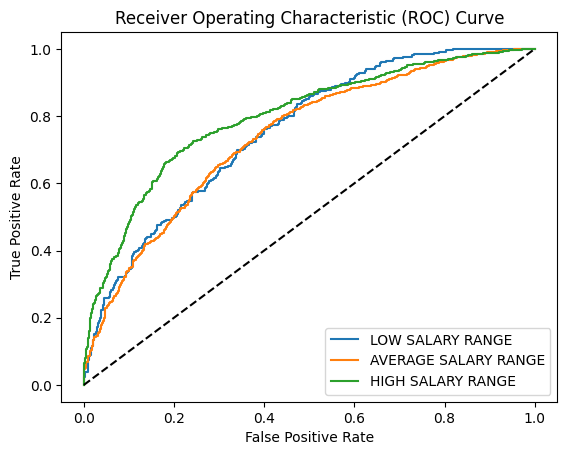

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)
# y_pred_lr = model.predict(x_test)
train_scores(model,'Logistic Regression',3)

****** For Testing on Logistic Regression Model ******

The Confusion Matrix:
 [[  2  66   7]
 [  6 286  68]
 [  0 103  93]]

 The Accuray Score: 0.6038034865293186

 The Recall Score: 0.4744897959183674

 The Precision Score: 0.5535714285714286

 The F1 Score: 0.5109890109890111

 The ROC AUC Score: 0.5814632518095323


Class 0 Corresponds to LOW SALARY RANGE
Class 1 Corresponds to AVERAGE SALARY RANGE
Class 2 Corresponds to HIGH SALARY RANGE




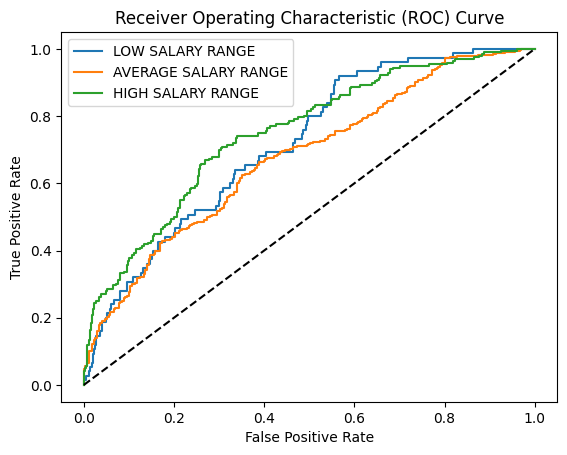

In [ ]:
test_scores(model,'Logistic Regression',3)

### Decision Tree Classifier

****** For Training on  Decision Tree Classifier Model ******

The Confusion Matrix:
 [[ 256    0    0]
 [   0 1164    0]
 [   0    0  691]]

 The Accuray Score: 1.0

 The Recall Score: 1.0

 The Precision Score: 1.0

 The F1 Score: 1.0

 The ROC AUC Score: 1.0


Class 0 Corresponds to LOW SALARY RANGE
Class 1 Corresponds to AVERAGE SALARY RANGE
Class 2 Corresponds to HIGH SALARY RANGE




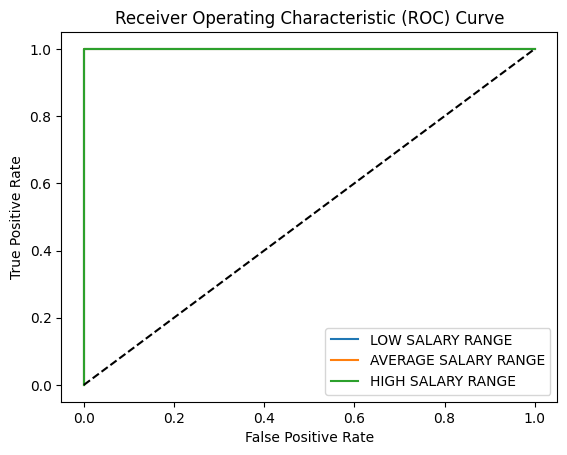

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model1 = DecisionTreeClassifier()
model1.fit(x_train, y_train)
#y_pred_dt = model1.predict(x_test)
train_scores(model1,'Decision Tree Classifier',3)

****** For Testing on Decision Tree Classifier Model ******

The Confusion Matrix:
 [[ 69   3   3]
 [  4 343  13]
 [  0   7 189]]

 The Accuray Score: 0.9524564183835182

 The Recall Score: 0.9642857142857143

 The Precision Score: 0.9219512195121952

 The F1 Score: 0.942643391521197

 The ROC AUC Score: 0.9593645448766805


Class 0 Corresponds to LOW SALARY RANGE
Class 1 Corresponds to AVERAGE SALARY RANGE
Class 2 Corresponds to HIGH SALARY RANGE




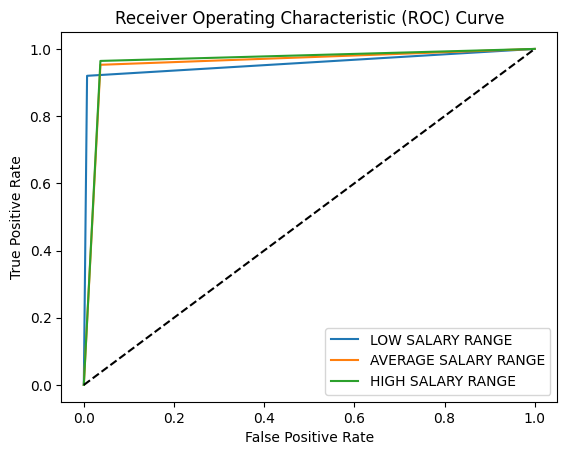

In [ ]:
test_scores(model1,'Decision Tree Classifier',3)

### Random Forest Classifier

****** For Training on  Random Forest Classifier Model ******

The Confusion Matrix:
 [[ 256    0    0]
 [   0 1164    0]
 [   0    0  691]]

 The Accuray Score: 1.0

 The Recall Score: 1.0

 The Precision Score: 1.0

 The F1 Score: 1.0

 The ROC AUC Score: 1.0


Class 0 Corresponds to LOW SALARY RANGE
Class 1 Corresponds to AVERAGE SALARY RANGE
Class 2 Corresponds to HIGH SALARY RANGE




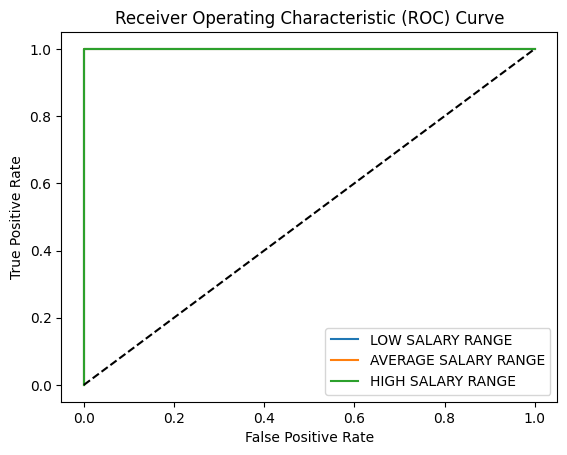

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier()
model2.fit(x_train, y_train)
#y_pred_knn = model2.predict(x_test)
train_scores(model2,'Random Forest Classifier',3)

****** For Testing on Random Forest Classifier Model ******

The Confusion Matrix:
 [[ 13  57   5]
 [ 18 310  32]
 [  7  76 113]]

 The Accuray Score: 0.6909667194928685

 The Recall Score: 0.576530612244898

 The Precision Score: 0.7533333333333333

 The F1 Score: 0.6531791907514451

 The ROC AUC Score: 0.6650297748164865


Class 0 Corresponds to LOW SALARY RANGE
Class 1 Corresponds to AVERAGE SALARY RANGE
Class 2 Corresponds to HIGH SALARY RANGE




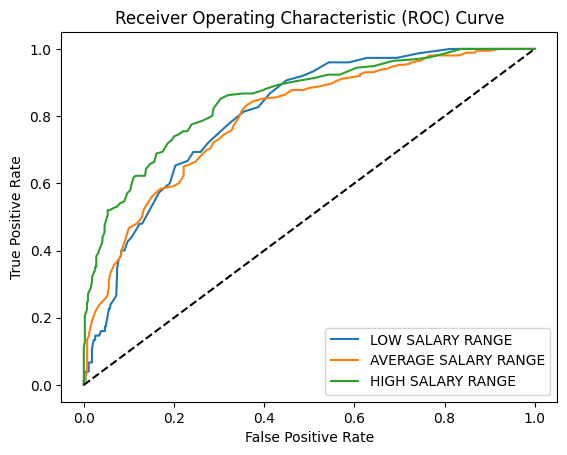

In [ ]:
test_scores(model2,'Random Forest Classifier',3)

### KNN Classifier

****** For Training on  KNN Classifier Model ******

The Confusion Matrix:
 [[ 92 145  19]
 [ 67 966 131]
 [ 30 223 438]]

 The Accuray Score: 0.708668877309332

 The Recall Score: 0.6338639652677279

 The Precision Score: 0.7448979591836735

 The F1 Score: 0.684910086004691

 The ROC AUC Score: 0.712769233267351


Class 0 Corresponds to LOW SALARY RANGE
Class 1 Corresponds to AVERAGE SALARY RANGE
Class 2 Corresponds to HIGH SALARY RANGE




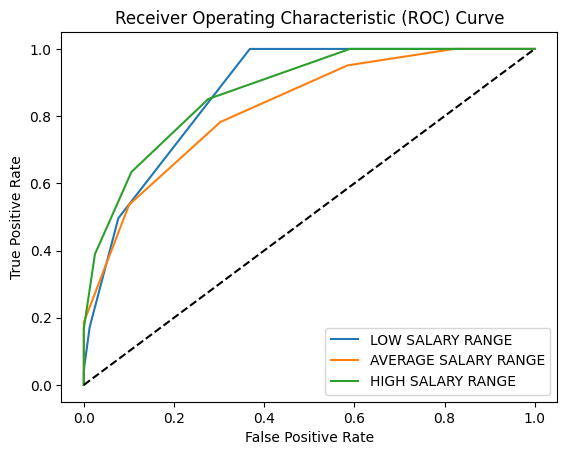

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model3 = KNeighborsClassifier(n_neighbors=5)
model3.fit(x_train, y_train)
#y_pred_knn = model3.predict(x_test)
train_scores(model3,'KNN Classifier',3)

****** For Testing on KNN Classifier Model ******

The Confusion Matrix:
 [[ 14  55   6]
 [ 41 259  60]
 [ 15 101  80]]

 The Accuray Score: 0.5594294770206022

 The Recall Score: 0.40816326530612246

 The Precision Score: 0.547945205479452

 The F1 Score: 0.46783625730994155

 The ROC AUC Score: 0.5810308429280339


Class 0 Corresponds to LOW SALARY RANGE
Class 1 Corresponds to AVERAGE SALARY RANGE
Class 2 Corresponds to HIGH SALARY RANGE




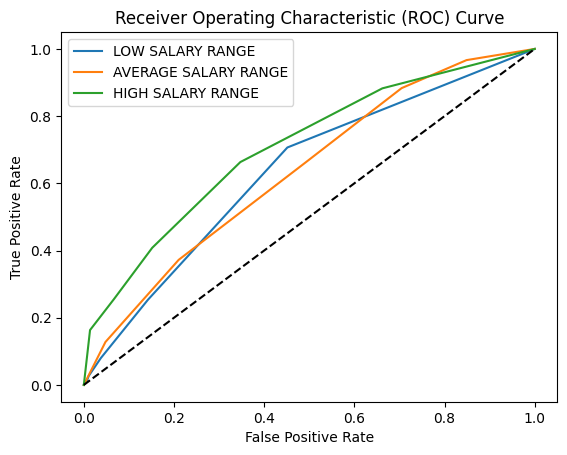

In [ ]:
test_scores(model3,'KNN Classifier',3)

### Gradient Boosting Classifier

****** For Training on  Gradient Boosting Classifier Model ******

The Confusion Matrix:
 [[ 224   32    0]
 [   2 1154    8]
 [   1   46  644]]

 The Accuray Score: 0.9578398863098058

 The Recall Score: 0.9319826338639653

 The Precision Score: 0.9877300613496932

 The F1 Score: 0.9590469099032018

 The ROC AUC Score: 0.9514625251287953


Class 0 Corresponds to LOW SALARY RANGE
Class 1 Corresponds to AVERAGE SALARY RANGE
Class 2 Corresponds to HIGH SALARY RANGE




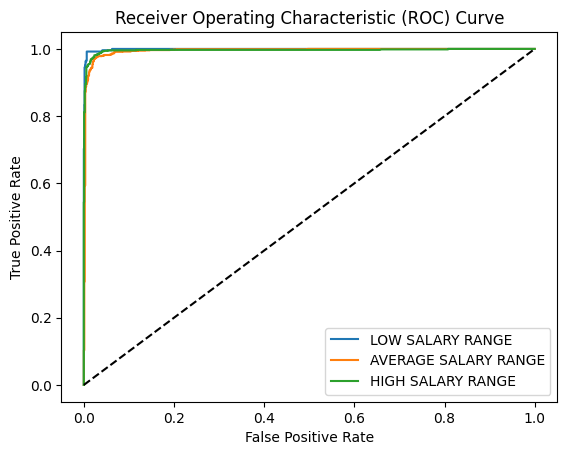

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model4 = GradientBoostingClassifier()
model4.fit(x_train, y_train)
train_scores(model4,'Gradient Boosting Classifier',3)

****** For Testing on Gradient Boosting Classifier Model ******

The Confusion Matrix:
 [[ 58  14   3]
 [  2 349   9]
 [  0  20 176]]

 The Accuray Score: 0.9239302694136292

 The Recall Score: 0.8979591836734694

 The Precision Score: 0.9361702127659575

 The F1 Score: 0.9166666666666666

 The ROC AUC Score: 0.914015396273332


Class 0 Corresponds to LOW SALARY RANGE
Class 1 Corresponds to AVERAGE SALARY RANGE
Class 2 Corresponds to HIGH SALARY RANGE




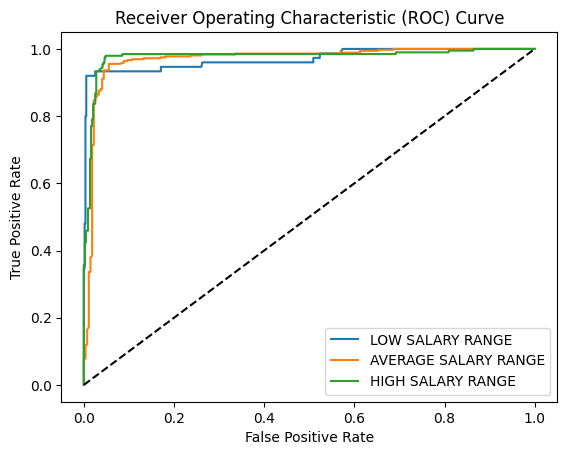

In [ ]:
test_scores(model4,'Gradient Boosting Classifier',3)